In [93]:
import nbimporter
import networkx as nx
import random
from matplotlib import pyplot as plt
from brute_force import brute_force
from functools import wraps
import time
from tqdm import tqdm

In [98]:
for _ in tqdm(range(50), desc="Test bar", leave=False):
    time.sleep(0.3)


Test bar: 100%|█████████████████████████████████| 50/50 [00:15<00:00,  3.30it/s]
                                                                                

In [77]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.6f} seconds")
        return result
    return wrapper

In [78]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight = "weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight = "weight")
    best_w = best_tree.size(weight = "weight")
    best_nodes = set(best_tree.nodes())

    return best_tree, best_w, best_nodes

In [79]:
def evaluate(G, nodes):
    subgraph = G.subgraph(nodes)
    if not nx.is_connected(subgraph):
        return None, float("inf")
    T = nx.minimum_spanning_tree(subgraph, weight = "weight")
    return T, T.size(weight = "weight")

In [80]:
def shake(G, current_nodes, k, terminals):
    nodes = list(set(G.nodes()) - set(terminals))
    new_nodes = set(current_nodes)
    
    for _ in range(k):
        if random.random() < 0.5 and len(new_nodes - set(terminals)) > 0:
            v = random.choice(list(new_nodes - set(terminals)))
            new_nodes.remove(v)
        else:
            v = random.choice(nodes)
            new_nodes.add(v)
    return new_nodes

In [81]:
def local_search(G, nodes, terminals):
    improved = True
    best_nodes = set(nodes)
    best_tree, best_w = evaluate(G, best_nodes)
    
    while improved:
        improved = False
        for v in list(best_nodes - set(terminals)):
            candidate = best_nodes - {v}
            T, w = evaluate(G, candidate)
            if w < best_w:
                best_nodes, best_tree, best_w = candidate, T, w
                improved = True
                break
    return best_tree, best_w, best_nodes

In [105]:
@timeit
def vns(G, terminals, iterations, max_k):
    best_tree, best_w, best_nodes = initialize(G, terminals)

    pbar = tqdm(total=iterations, desc = "Variable neighborhood search", leave = False, mininterval = 1.0)
    for _ in range(iterations):
        k = 1
        while k <= max_k:
            shaken_nodes = shake(G, best_nodes, k, terminals)
            T, w = evaluate(G, shaken_nodes)
            
            if w == float("inf"):
                k += 1
                continue

            T_ls, w_ls, nodes_ls = local_search(G, shaken_nodes, terminals)
            
            if w_ls < best_w:
                best_tree, best_w, best_nodes = T_ls, w_ls, nodes_ls
                k = 1
            else:
                k += 1
        
        pbar.update(1)

    pbar.close()
    
    return best_tree, best_w

In [83]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [84]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [85]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

vns took 0.183018 seconds


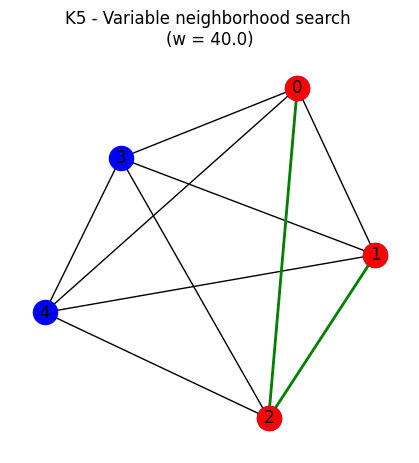

vns took 0.190043 seconds


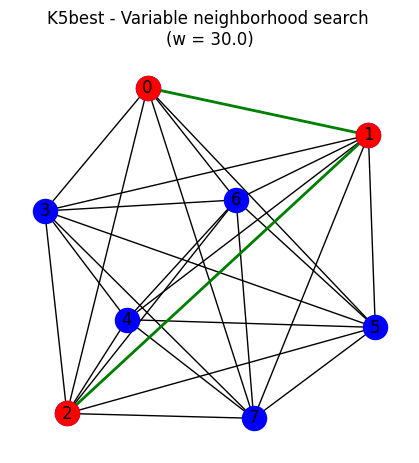

vns took 0.179004 seconds


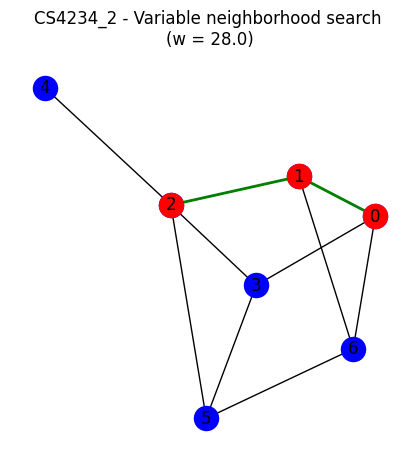

In [106]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w = vns(G, terminals, 100, 5)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

    plt.title(f"{name} - Variable neighborhood search \n(w = {w})")
    plt.show()

In [87]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [107]:
G, terminals = read_stp('hc6u.stp')

vns took 0.903041 seconds


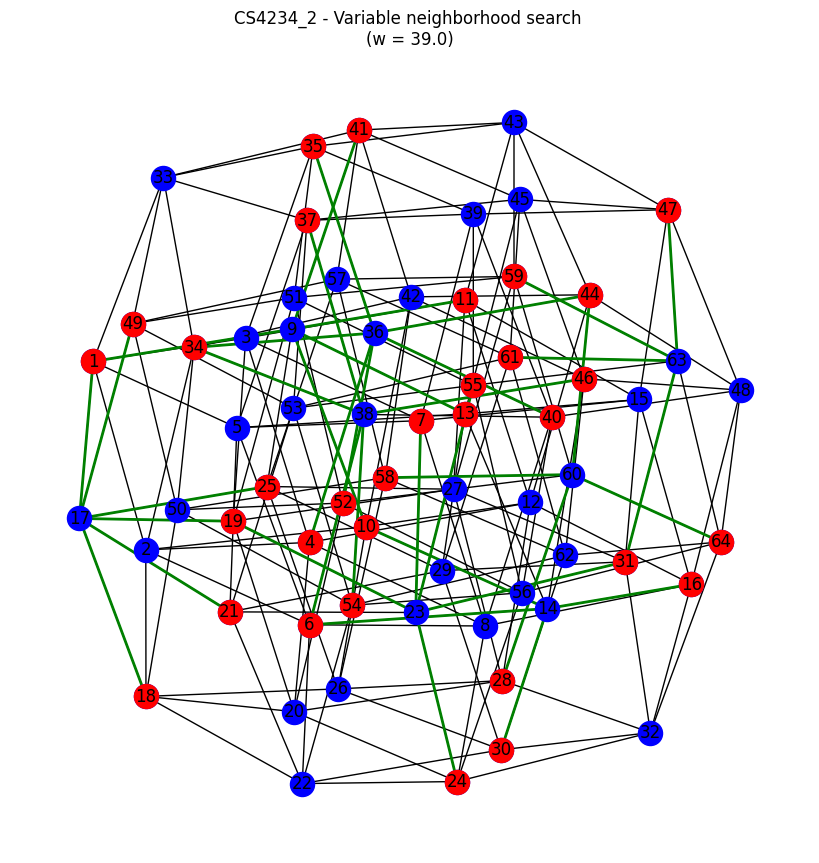

In [108]:
pos = nx.spring_layout(G, seed = 42)
T, w = vns(G, terminals, 100, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
# edge_labels = nx.get_edge_attributes(G, "weight") 
# nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Variable neighborhood search \n(w = {w})")
plt.show()

In [109]:
G, terminals = read_stp('hc12u.stp')

In [ ]:
pos = nx.spring_layout(G, seed = 42)
T, w = vns(G, terminals, 100, 5)
    
plt.figure(figsize = (4,4))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Variable neighborhood search  \n(w = {w})")
plt.show()